In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import rasterio
import numpy as np
from torchvision.io import read_image
from torchvision.transforms import ToTensor, Normalize
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch.utils.data.dataset import Subset
from sklearn.metrics import classification_report
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
tqdm.pandas()

/work/scorreacardo_umass_edu/miniconda3/envs/urbano2/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class SensorDataset(Dataset):
    def __init__(self, root_dir, transform=None, max_black_pixels=0.4, max_white_pixels=0.4):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = sorted(os.listdir(root_dir))
        self.filepaths = []
        self.labels = []

        for i, sensor_class in enumerate(self.classes):
            class_dir = os.path.join(root_dir, sensor_class)
            for filename in [f for f in os.listdir(class_dir) if f.startswith("row")]:
                filepath = os.path.join(class_dir, filename)
                self.filepaths.append(filepath)
                self.labels.append(i)
                
        # Prune the dataset based on black and white pixel percentages
        self.prune_dataset(max_black_pixels, max_white_pixels)
        # Calculate mean and standard deviation of the dataset
        # self.mean, self.std = self.calculate_statistics()

    def __len__(self):
        return len(self.filepaths)

    def __getitem__(self, index):
        filepath = self.filepaths[index]
        label = self.labels[index]

        with rasterio.open(filepath, 'r') as img:
            image = img.read().transpose(1, 2, 0)

        if self.transform:
            image = self.transform(image)

        return image, label
    
    def prune_dataset(self, max_black_pixels, max_white_pixels):
        pruned_filepaths = []
        pruned_labels = []
        channels_sum = np.zeros((3,))
        channels_squared_sum = np.zeros((3,))

        for filepath, label in tqdm(zip(self.filepaths, self.labels)):
            with rasterio.open(filepath, 'r') as img:
                image = img.read().transpose(1, 2, 0)  # Transpose to (H, W, C) (512,512,3)

            # Calculate the percentage of black and white pixels
            total_pixels = np.prod(image.shape)
            black_pixels = np.sum(image == 0)
            white_pixels = np.sum(image == 255)
            black_pixel_percentage = black_pixels / total_pixels
            white_pixel_percentage = white_pixels / total_pixels

            # Prune the image if it falls outside the specified range
            if black_pixel_percentage <= max_black_pixels and white_pixel_percentage <= max_white_pixels:
                pruned_filepaths.append(filepath)
                pruned_labels.append(label)
                
                channels_sum += np.sum(image, axis=(0, 1))
                channels_squared_sum += np.sum(np.square(image), axis=(0, 1))
                

        self.filepaths = pruned_filepaths
        self.labels = pruned_labels
        num_samples = len(self.filepaths)
        self.mean = channels_sum / (num_samples * image.shape[0] * image.shape[1])
        variance = (channels_squared_sum / (num_samples * image.shape[0] * image.shape[1])) - np.square(self.mean)
        variance = np.maximum(variance, 1e-8)  # Clip variance to a minimum value of epsilon
        self.std = np.sqrt(variance)
        
        self.mean = self.mean.tolist()
        self.std = self.std.tolist()
        

In [4]:
# Set the directory paths for train, validation, and test
train_dir = "/work/scorreacardo_umass_edu/DeepSatGSD/data/processed/train"
validation_dir = "/work/scorreacardo_umass_edu/DeepSatGSD/data/processed/validation"
test_dir = "/work/scorreacardo_umass_edu/DeepSatGSD/data/processed/test"

# Define the image transformation
image_transform = ToTensor()  # Add other transformations as needed

# # Create the datasets
train_dataset = SensorDataset(train_dir, transform=image_transform)
# validation_dataset = SensorDataset(validation_dir, transform=image_transform)
# test_dataset = SensorDataset(test_dir, transform=image_transform)

# # Create the data loaders for batching and shuffling
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
# validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=32, shuffle=True)
# test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True)

41662it [18:26, 37.65it/s]


In [5]:
 #
  # True standard deviation
  #
mean = 0.0
meansq = 0.0
count = 0
import pdb
for index, data in tqdm(enumerate(train_loader)):
    #pdb.set_trace()
    batch_size = data[0].shape[0]
    data_batch = data[0]  # Concatenate tensors from the list
    mean += data_batch.sum(dim=(0, 2, 3))
    meansq += (data_batch **2).sum(dim=(0, 2, 3))
    count += batch_size * data_batch .shape[2] * data_batch.shape[3]

total_mean = mean / count
total_var = (meansq / count) - (total_mean**2)
total_std = torch.sqrt(total_var)
print("mean: " + str(total_mean.tolist()))
print("std: " + str(total_std.tolist()))

728it [02:04,  5.83it/s]

mean: [0.47193989157676697, 0.42456501722335815, 0.3104502260684967]
std: [0.19043418765068054, 0.16198454797267914, 0.1568923145532608]


### Let's start the training

In [3]:
# Set the device (GPU if available, otherwise CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Set the training parameters
batch_size = 16 #bajar
num_epochs = 20
learning_rate = 0.0001

# Set the path to your train, validation, and test directories
train_dir = "/work/scorreacardo_umass_edu/DeepSatGSD/data/processed/train"
validation_dir = "/work/scorreacardo_umass_edu/DeepSatGSD/data/processed/validation"
test_dir = "/work/scorreacardo_umass_edu/DeepSatGSD/data/processed/test"

# Define the image transformations
transform = torchvision.transforms.Compose([
    ToTensor(),
    Normalize([0.47193989157676697, 0.42456501722335815, 0.3104502260684967], 
              [0.19043418765068054, 0.16198454797267914, 0.1568923145532608])  # Normalize image tensors
])

# Create custom datasets
train_dataset = SensorDataset(train_dir, transform=transform)
validation_dataset = SensorDataset(validation_dir, transform=transform)
test_dataset = SensorDataset(test_dir, transform=transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

41662it [13:09, 52.79it/s]
8037it [02:27, 54.61it/s]
9828it [03:02, 53.81it/s]


In [ ]:
# Load the pre-trained ResNet model
model = torchvision.models.resnet18(pretrained=True)
num_classes = len(train_dataset.classes)

# Modify the last fully connected layer to match the number of classes
model.fc = nn.Linear(model.fc.in_features, num_classes)

# Move the model to the device
model = model.to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

learning_courve = []
# Training loop
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Print the training loss for each epoch
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}")
    learning_courve.append([epoch+1, loss.item()])

Epoch [1/20], Loss: 0.032267555594444275
Epoch [2/20], Loss: 2.841430187225342
Epoch [3/20], Loss: 0.027360348030924797
Epoch [4/20], Loss: 1.7523897886276245
Epoch [5/20], Loss: 3.675311803817749
Epoch [6/20], Loss: 1.2990950345993042
Epoch [7/20], Loss: 0.00035614546504803
Epoch [8/20], Loss: 0.00010859027679543942
Epoch [9/20], Loss: 0.5381330251693726
Epoch [10/20], Loss: 8.536701202392578
Epoch [11/20], Loss: 2.9630210399627686
Epoch [12/20], Loss: 1.119680404663086
Epoch [13/20], Loss: 5.598230361938477
Epoch [14/20], Loss: 2.560121774673462
Epoch [15/20], Loss: 11.220598220825195
Epoch [16/20], Loss: 0.020287055522203445
Epoch [19/20], Loss: 6.100793361663818


In [9]:
# Evaluation on validation set
model.eval()  # Set the model to evaluation mode
total_correct = 0
total_samples = 0
predicted_labels = []
true_labels = []

with torch.no_grad():
    for images, labels in validation_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        total_samples += labels.size(0)
        total_correct += (predicted == labels).sum().item()

        predicted_labels.extend(predicted.tolist())
        true_labels.extend(labels.tolist())

validation_accuracy = total_correct / total_samples
print(f"Validation Accuracy: {validation_accuracy}")

# Compute additional performance metrics
classification_metrics = classification_report(true_labels, predicted_labels, target_names=validation_dataset.classes)
print("Classification Report:")
print(classification_metrics)

# Evaluation on test set
model.eval()  # Set the model to evaluation mode
total_correct = 0
total_samples = 0
predicted_labels = []
true_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        total_samples += labels.size(0)
        total_correct += (predicted == labels).sum().item()

        predicted_labels.extend(predicted.tolist())
        true_labels.extend(labels.tolist())

test_accuracy = total_correct / total_samples
print(f"Test Accuracy: {test_accuracy}")

# Compute additional performance metrics
classification_metrics = classification_report(true_labels, predicted_labels, target_names=test_dataset.classes)
print("Classification Report:")
print(classification_metrics)

Validation Accuracy: 0.9045721476510067
Classification Report:
              precision    recall  f1-score   support

        GE01       0.85      0.90      0.88      1137
        QB02       0.91      0.98      0.95      1258
        WV02       0.95      0.91      0.93      1588
   WV03_VNIR       0.87      0.79      0.83       785

    accuracy                           0.90      4768
   macro avg       0.90      0.89      0.89      4768
weighted avg       0.91      0.90      0.90      4768

Test Accuracy: 0.8547895057962172
Classification Report:
              precision    recall  f1-score   support

        GE01       0.63      0.99      0.77      1403
        QB02       0.95      0.98      0.97      1713
        WV02       0.96      0.85      0.90      1201
   WV03_VNIR       0.99      0.68      0.81      2239

    accuracy                           0.85      6556
   macro avg       0.88      0.87      0.86      6556
weighted avg       0.90      0.85      0.86      6556



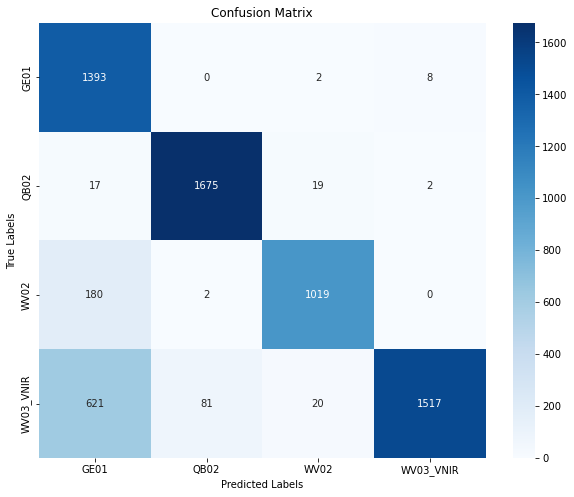

In [10]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
# Compute the confusion matrix
confusion_mat = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix using seaborn
class_names = train_dataset.classes  # Assuming you have access to the class names
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mat, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()